## Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# Load the data
train_set = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

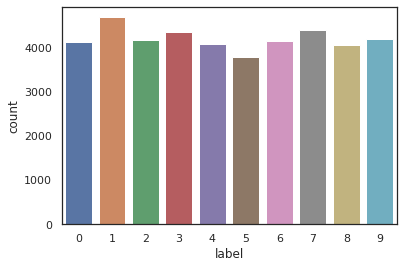

In [3]:
Y_train = train_set["label"]

# Drop 'label' column
X_train = train_set.drop(labels = ["label"],axis = 1) 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [5]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [6]:
# reshape 3D images (depth is only 1 because it is grayscale images)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [7]:
# onehot encoding labels for keras needs
Y_train = to_categorical(Y_train, num_classes = 10)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.05, random_state=2)

In [11]:
model = Sequential()

# Each filter transforms a part of the image using the kernel filter
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                 activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                 activation='relu'))

#  takes 2*2 neighbor pixels and picks the maximal value
# reduce computational cost and overfitting
model.add(MaxPool2D(pool_size=(2, 2)))
# reduce overfitting : nodes in the layer are randomly ignored
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# convert feature maps into a 1D vector
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
# outputs 10 numbers
model.add(Dense(10, activation="softmax"))


In [15]:
# Compile the model (default params)
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08,
                                decay=0.0), loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
# reducing learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Data augmentation

Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. More data beats cleaver algorithms.

In [21]:
data_augmentation = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10, # randomly rotate images
    zoom_range=0.1,  # randomly zoom image
    width_shift_range=0.1, # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    horizontal_flip=False, # randomly flip images
    vertical_flip=False) # randomly flip images

data_augmentation.fit(X_train)

In [22]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=30),
                              epochs=20, validation_data=(X_val, Y_val),
                              verbose=2, steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/20
 - 104s - loss: 0.2979 - accuracy: 0.9074 - val_loss: 0.0825 - val_accuracy: 0.9805
Epoch 2/20


/home/quentin/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 105s - loss: 0.1162 - accuracy: 0.9652 - val_loss: 0.0306 - val_accuracy: 0.9905
Epoch 3/20
 - 115s - loss: 0.0975 - accuracy: 0.9734 - val_loss: 0.0442 - val_accuracy: 0.9886
Epoch 4/20
 - 113s - loss: 0.0994 - accuracy: 0.9729 - val_loss: 0.0428 - val_accuracy: 0.9914
Epoch 5/20
 - 109s - loss: 0.1000 - accuracy: 0.9736 - val_loss: 0.0778 - val_accuracy: 0.9843
Epoch 6/20
 - 109s - loss: 0.1058 - accuracy: 0.9729 - val_loss: 0.0454 - val_accuracy: 0.9905
Epoch 7/20
 - 107s - loss: 0.1090 - accuracy: 0.9717 - val_loss: 0.0952 - val_accuracy: 0.9824
Epoch 8/20
 - 107s - loss: 0.1140 - accuracy: 0.9726 - val_loss: 0.0895 - val_accuracy: 0.9857
Epoch 9/20
 - 109s - loss: 0.1194 - accuracy: 0.9716 - val_loss: 0.1197 - val_accuracy: 0.9752
Epoch 10/20
 - 115s - loss: 0.1271 - accuracy: 0.9697 - val_loss: 0.0928 - val_accuracy: 0.9843
Epoch 11/20
 - 114s - loss: 0.1303 - accuracy: 0.9692 - val_loss: 0.0643 - val_accuracy: 0.9871
Epoch 12/20
 - 111s - loss: 0.1324 - accuracy: 0.9698 - val

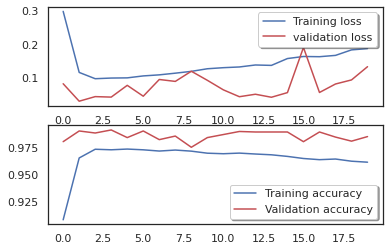

In [25]:
# learning curves
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

We reach our best accuracy around the third epoch

### Predictions

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       221
           1       0.98      1.00      0.99       247
           2       0.99      0.99      0.99       204
           3       0.99      0.98      0.98       204
           4       0.97      0.99      0.98       225
           5       0.98      0.98      0.98       188
           6       0.98      0.97      0.98       198
           7       1.00      1.00      1.00       205
           8       0.98      0.98      0.98       198
           9       0.98      0.98      0.98       210

    accuracy                           0.99      2100
   macro avg       0.99      0.98      0.99      2100
weighted avg       0.99      0.99      0.99      2100



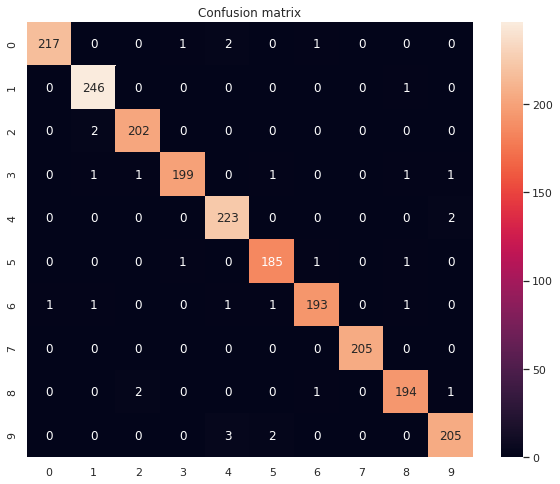

In [33]:
y_pred = model.predict(X_val)
#  get prediction classes
y_pred_cls = np.argmax(Y_pred,axis = 1) 
# get observations 
y_test = np.argmax(Y_val,axis = 1) 

import sklearn.metrics as sklm
print(sklm.classification_report(y_test, y_pred_cls))

conf = sklm.confusion_matrix(y_test, y_pred_cls)
plt.figure(figsize=(10, 8))
plt.title('Confusion matrix')
sns.heatmap(conf, annot=True, fmt='d');